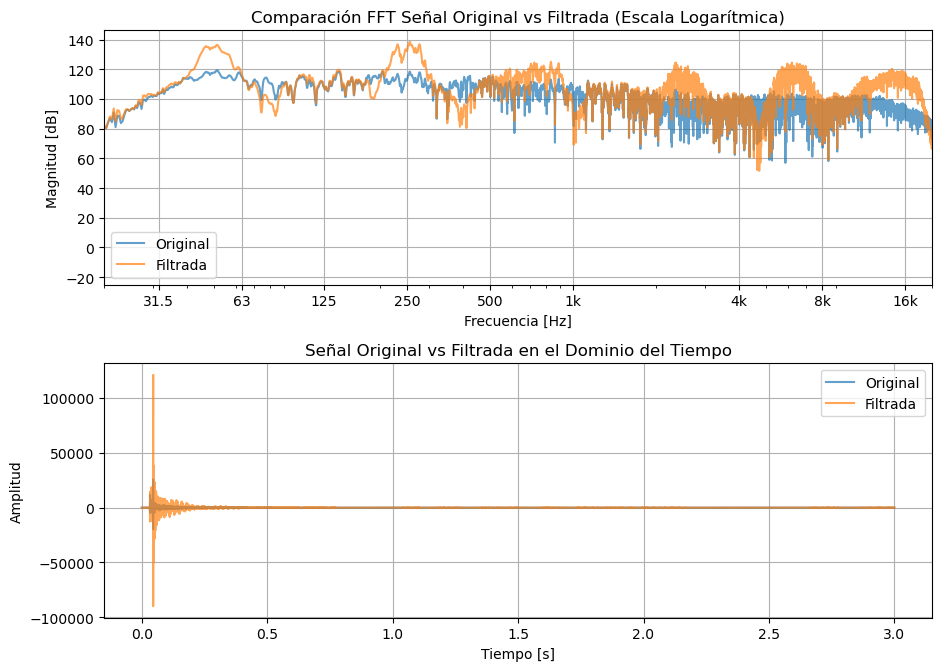

In [8]:
import tkinter as tk
from tkinter import Scale, Label, Button, filedialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from scipy.signal import butter, sosfilt
from scipy.fft import fft, fftfreq
from scipy.io import wavfile

# Inicializar variables globales
fs = None  # Frecuencia de muestreo
x = None   # Señal de audio

# Frecuencias centrales de tercio de octava, agregando 18000 Hz y 20000 Hz
fto_nom = np.array([20, 25, 31.5,
                    40, 50, 63,
                    80, 100, 125,
                    160, 200, 250,
                    315, 400, 500, 
                    630, 800, 1000,
                    1250, 1600, 2000,
                    2500, 3150, 4000,
                    5000, 6300, 8000,
                    10000, 12500, 16000,
                    18000, 20000])  # Agregar las nuevas frecuencias

# Crear lista para almacenar los valores de los faders (inicializados en 0 dB)
fader_valores = [0.0] * len(fto_nom)  # Iniciar todos los faders en 0 dB

# Crear ventana principal
ventana = tk.Tk()
ventana.title("Interfaz con Faders y Gráfica FFT")
ventana.geometry("900x750")  # Aumentar el tamaño de la ventana para más espacio

# Crear marco para los faders
frame_faders = tk.Frame(ventana)
frame_faders.pack(side=tk.LEFT, padx=10, pady=10)

def fto_lim(fto_nom):
    """Calcula los límites inferiores y superiores para tercios de octava."""
    fto_inf = fto_nom * 2 ** (-1/6)  # Banda inferior
    fto_sup = fto_nom * 2 ** (1/6)   # Banda superior
    return fto_inf, fto_sup

def but_pb(inf, sup, fs=fs, order=4):
    """Obtención de los coeficientes para el diseño del filtro."""
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    low = inf / nyq
    high = sup / nyq
    
    # Comprobar si las frecuencias de corte están dentro del rango permitido
    if low <= 0 or high >= 1:
        #print(f"Frecuencia fuera de rango: low={low}, high={high}. Omitiendo filtro.")
        return None  # Devolver None si las frecuencias están fuera de rango
    
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def but_pb_filt(x, inf, sup, fs=fs, order=4):
    """Filtrado de la señal."""
    sos = but_pb(inf, sup, fs=fs, order=order)
    if sos is None:
        return np.zeros_like(x)  # Devolver una señal de ceros si las frecuencias están fuera de rango
    return sosfilt(sos, x)

def db_to_gain(db_value):
    """Convierte ganancia en dB a factor lineal."""
    return 10 ** (db_value / 20)

def filt_to(x, fto_nom=fto_nom, gain_values_db=fader_valores):
    """Filtrado de la señal por bandas de tercio de octava, aplicando las ganancias en dB."""
    fto_inf, fto_sup = fto_lim(fto_nom)
    y = np.zeros([len(fto_nom), len(x)])
    for i in range(len(fto_nom)):
        band_filtered = but_pb_filt(x, fto_inf[i], fto_sup[i], fs=fs)
        gain = db_to_gain(gain_values_db[i])
        y[i] = band_filtered * gain
    return y

def combine_bands(y):
    """Suma todas las bandas filtradas con ganancia."""
    return np.sum(y, axis=0)

# Función para calcular y graficar la FFT y la señal en el dominio del tiempo
def plot_fft_and_time_comparison(original_signal, filtered_signal, fs):
    # FFT de la señal original
    N = len(original_signal)
    original_fft = fft(original_signal)
    original_fft_magnitude = np.abs(original_fft)  # Magnitud de la FFT
    freqs = fftfreq(N, 1 / fs)  # Frecuencias correspondientes
    
    # FFT de la señal filtrada
    filtered_fft = fft(filtered_signal)
    filtered_fft_magnitude = np.abs(filtered_fft)

    epsilon = 1e-10  # Pequeño valor para evitar log(0)
    xtick_labels = [31.5, 63, 125, 250, 500, 1000, 4000, 8000, 16000]
    xtick_labels_str = ['31.5', '63', '125', '250', '500', '1k', '4k', '8k', '16k']

    # ======= Actualizar el gráfico FFT (eje de frecuencias) =======
    ax1.clear()  # Limpiar la gráfica antes de actualizar
    ax1.semilogx(freqs[:N//2], 20 * np.log10(original_fft_magnitude[:N//2] + epsilon), label="Original", alpha=0.7)
    ax1.semilogx(freqs[:N//2], 20 * np.log10(filtered_fft_magnitude[:N//2] + epsilon), label="Filtrada", alpha=0.7)
    
    # Configurar etiquetas del eje x para FFT
    ax1.set_xticks(xtick_labels)
    ax1.set_xticklabels(xtick_labels_str)
    
    ax1.set_title("Comparación FFT Señal Original vs Filtrada (Escala Logarítmica)")
    ax1.set_xlabel("Frecuencia [Hz]")
    ax1.set_ylabel("Magnitud [dB]")
    ax1.set_xlim([20, 20000])
    ax1.legend()
    ax1.grid(True)

    # ======= Actualizar el gráfico en el dominio del tiempo =======
    t = np.arange(0, len(original_signal) / fs, 1/fs)  # Eje de tiempo
    ax2.clear()  # Limpiar la gráfica antes de actualizar
    ax2.plot(t, original_signal, label="Original", alpha=0.7)
    ax2.plot(t, filtered_signal, label="Filtrada", alpha=0.7)
    
    ax2.set_title("Señal Original vs Filtrada en el Dominio del Tiempo")
    ax2.set_xlabel("Tiempo [s]")
    ax2.set_ylabel("Amplitud")
    ax2.legend()
    ax2.grid(True)

    # Ajustar los espacios entre las gráficas para evitar solapamientos
    fig.tight_layout()  # Ajusta los márgenes automáticamente para evitar solapamientos
    canvas.draw()

# Función para actualizar la gráfica al mover los faders
def actualizar_grafica():
    if fs is None or x is None:
        return  # Si no hay archivo cargado, no hacer nada
    # Filtrar la señal con las ganancias actuales de los faders
    y = filt_to(x, fto_nom, fader_valores)
    # Combinar todas las bandas para obtener la señal final filtrada
    output_signal = combine_bands(y)
    # Comparar la FFT de la señal original vs la señal filtrada y también en el dominio del tiempo
    plot_fft_and_time_comparison(x, output_signal, fs)

# Función para cargar un archivo WAV
def cargar_archivo_wav():
    global fs, x
    # Abrir un cuadro de diálogo para seleccionar el archivo
    archivo_wav = filedialog.askopenfilename(filetypes=[("Archivo WAV", "*.wav")])
    if archivo_wav:
        # Cargar el archivo WAV
        fs, x = wavfile.read(archivo_wav)
        x = x.astype(np.float32)  # Convertir a float para evitar problemas de precisión
        if len(x.shape) > 1:
            x = x[:, 0]  # Si es estéreo, tomar solo un canal
        actualizar_grafica()  # Actualizar la gráfica después de cargar el archivo

# Botón para cargar archivo WAV
boton_cargar = Button(ventana, text="Cargar WAV", command=cargar_archivo_wav)
boton_cargar.pack(side=tk.TOP, pady=10)

# Crear los faders (escala deslizante) con etiquetas de frecuencia
for i in range(16):  # Ahora iteramos sobre 16 filas en lugar de 15, por las nuevas frecuencias
    # Crear fader 1
    fader1 = Scale(frame_faders, from_=-30, to=30, orient=tk.HORIZONTAL)
    fader1.grid(row=i, column=0)
    
    # Etiqueta para fader 1
    label_fader1 = Label(frame_faders, text=f"{int(fto_nom[i*2])} Hz")
    label_fader1.grid(row=i, column=1)
    
    # Crear fader 2
    fader2 = Scale(frame_faders, from_=-30, to=30, orient=tk.HORIZONTAL)
    fader2.grid(row=i, column=2)
    
    # Etiqueta para fader 2
    label_fader2 = Label(frame_faders, text=f"{int(fto_nom[i*2 + 1])} Hz")
    label_fader2.grid(row=i, column=3)
    
    # Actualizar el valor de los faders
    def actualizar_valor(indice, fader):
        def actualizacion(event):
            fader_valores[indice] = fader.get()  # Actualizar el valor del fader
            actualizar_grafica()  # Llamar a la función de actualización de la gráfica
        return actualizacion

    fader1.bind("<Motion>", actualizar_valor(i*2, fader1))
    fader2.bind("<Motion>", actualizar_valor(i*2 + 1, fader2))

# Crear un marco para la gráfica
frame_grafica = tk.Frame(ventana)
frame_grafica.pack(side=tk.RIGHT, padx=10, pady=10, expand=True, fill=tk.BOTH)

# Crear figura de Matplotlib con dos subgráficas: una para la FFT y otra para el dominio del tiempo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))  # Aumentar el tamaño de la figura
canvas = FigureCanvasTkAgg(fig, master=frame_grafica)
canvas.draw()
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

# Iniciar el loop principal
ventana.mainloop()
